# LetsGrowMoreVIP - Data Science Intern
# Author - Archita K
# Advanced Level Task 2 - Next Word Prediction
Using Tensorflow and Keras library train a RNN, to predict the next word

# Importing the Libraries

In [37]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

# Loading the Dataset

In [38]:
path = '1661-0.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581888


# Splitting the dataset into each word in order but without the presence of some special characters

In [39]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

# Dictionary with each word in the data within the list of unique words as the key, and it’s significant portions as value

In [41]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

# Feature Engineering

In [42]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [43]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [44]:
print(X[0][0])

[False False False ... False False False]


# Building the Recurrent Neural Network (RNN)

In [45]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

# Training the Next Word Prediction Model

In [47]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Epoch 1/10
811/811 [==============================] - 231s 282ms/step - loss: 5.9222 - accuracy: 0.1121 - val_loss: 7.0429 - val_accuracy: 0.1007
Epoch 2/10
811/811 [==============================] - 227s 279ms/step - loss: 5.7866 - accuracy: 0.1493 - val_loss: 7.8670 - val_accuracy: 0.1080
Epoch 3/10
811/811 [==============================] - 228s 281ms/step - loss: 5.7354 - accuracy: 0.1786 - val_loss: 8.0244 - val_accuracy: 0.1080
Epoch 4/10
811/811 [==============================] - 227s 280ms/step - loss: 5.4300 - accuracy: 0.2140 - val_loss: 8.2101 - val_accuracy: 0.0954
Epoch 5/10
811/811 [==============================] - 228s 281ms/step - loss: 5.1237 - accuracy: 0.2524 - val_loss: 8.4173 - val_accuracy: 0.0904
Epoch 6/10
811/811 [==============================] - 228s 281ms/step - loss: 4.8570 - accuracy: 0.2957 - val_loss: 8.6244 - val_accuracy: 0.0879
Epoch 7/10
811/811 [==============================] - 228s 281ms/step - loss: 4.6267 - accuracy: 0.3365 - val_loss: 8.7423 -

# Saving the Model

In [48]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

# Evaluating the Next Word Prediction Model
### Accuracy

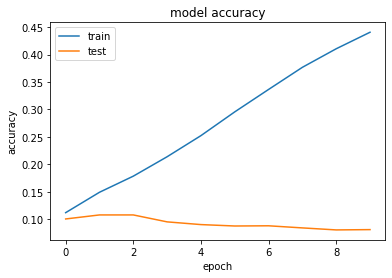

In [49]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Loss

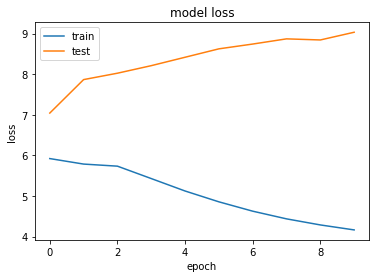

In [50]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Testing Next Word Prediction Model

In [51]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [52]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

# Creating a Function to Return Samples

In [53]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

# Creating a Function for Next Word Prediction

In [54]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [55]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [56]:
q =  "Suddenly there was the momentary gleam of light up in the direction of the ventilator, which vanished immediately, but"
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

Sequence:  suddenly there was the momentary
suddenly
there
was
the
momentary
next possible words:  ['with', 'a', 'that', 'in', 'was']
